In [2]:
import os, torch, torch.nn as nn, torchvision, matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from torchvision.io import read_image
train_folder = 'data/train/'

In [3]:
filenames=[]
for filename in os.listdir(train_folder):
    filenames.append(filename)

labels=[]
for filename in filenames:
    if filename[:3]=='dog':
        labels.append(1)
    else:
        labels.append(0)

classes={0:'cat', 1:'dog'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

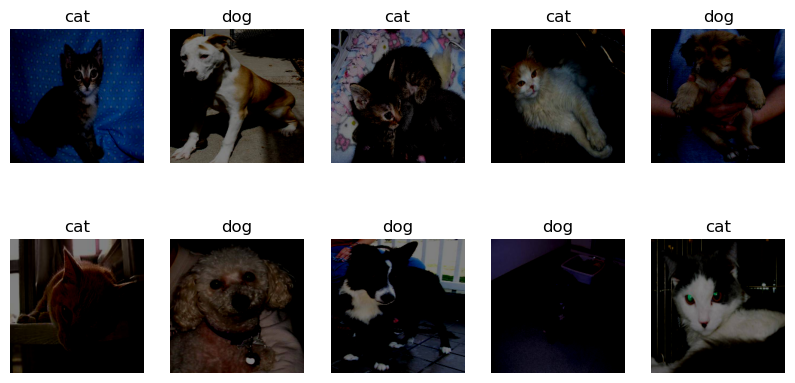

In [24]:
class CatAndDogDataset(Dataset):
    # Konstruktor
    # wenn wir dieses Datatset erstellen wollen --> CatAndDogDataset(filenames, labels, transform=transform)
    def __init__(self, filenames, labels, transform=None):
        self.filenames = filenames
        self.labels = labels
        self.transform = transform

    # Anzahl der Samples --> len(dataset)
    def __len__(self):
        return len(self.filenames)

    # Zugriff auf ein Sample --> dataset[i]
    # Was muss alles passieren, wenn ich ein Sample aus dem Dataset möchte?
    def __getitem__(self, idx):
        # Bild laden
        image = read_image(train_folder+self.filenames[idx])
        # Bild normalisieren, d.h. Wertebereich zwischen 0 und 1
        image = image/255.0 - 0.5
        # Label laden
        label = self.labels[idx]
        # Transformieren, sofern ein Transformator übergeben wurde
        if self.transform:
            image = self.transform(image)
        # Sample zurückgeben
        return image, label

# Transformator
transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224))
])

sample_dataset=CatAndDogDataset(filenames[:20], labels[:20], transform=transform)

# Dataloader, stellt die Daten für das Training zur Verfügung und kümmert sich um das Shuffeln und das Batching
sample_dataloader=DataLoader(sample_dataset, batch_size=10, shuffle=True)

# visualize a batch of images using the dataloader
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
index=0
for xb, yb in sample_dataloader:
    for row in range(2):
        for col in range(5):
            ax[row, col].imshow(xb[row*5+col].permute(1, 2, 0))  # permute --> 0, 1, 2 --> 1, 2, 0
            ax[row, col].set_title(classes[yb[row*5+col].item()])
            ax[row, col].axis('off')

In [25]:
X_train, X_test, y_train, y_test = train_test_split(filenames, labels, test_size=0.2, random_state=42, shuffle=True)

In [26]:
class DogsAndCatsModel(nn.Module):
    def __init__(self, p=0.2):
        super().__init__()
        self.layer1=torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=5, stride=2, padding=1),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(32),
            torch.nn.Dropout(p)
        )
        self.layer2=torch.nn.Sequential(
            torch.nn.Conv2d(32, 128, kernel_size=5, stride=2, padding=1),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(128),
            torch.nn.Dropout(p)
        )
        self.layer3=torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(256),
            torch.nn.Dropout(p)
        )

        self.fc1=torch.nn.Sequential(
            torch.nn.Linear(256*3*3, 300),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(300)
        )
        self.fc2=torch.nn.Sequential(
            torch.nn.Linear(300, 2),
            torch.nn.Softmax(dim=1)
        )

    def forward(self, xb):
        out=self.layer1(xb)
        out=self.layer2(out)
        out=self.layer3(out)
        out=out.reshape(out.size(0), -1)
        out=self.fc1(out)
        out=self.fc2(out)
        return out

model=DogsAndCatsModel()
model(xb).shape

torch.Size([10, 2])

In [27]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

mps


In [28]:
def get_accuracy(loader):
    correct=0
    for xb, yb in loader:
        xb=xb.to(device)
        yb=yb.to(device)
        y_hat=model(xb)
        y_pred=torch.argmax(y_hat, dim=1)
        correct+=(y_pred==yb).sum().item()
    return correct/len(loader)

In [29]:
batch_size=128

train_dataset=CatAndDogDataset(X_train, y_train, transform=transform)
test_dataset=CatAndDogDataset(X_test, y_test, transform=transform)
train_loader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader=DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [30]:
# eigenes Modell wird erstellt
model = DogsAndCatsModel().to(device)
lr=0.01

# loss function
# Mean Squared Error
# die Lossfunction von Pytorch müssen erstmal erstellt werden mit ()
loss_fn = nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=lr)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.6)

def train_batch(xb, yb):
    xb=xb.to(device)
    yb=yb.to(device)
    y_hat=model(xb)
    loss = loss_fn(y_hat, yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

def train_epoch(x, y):
    losses=[]
    for xb, yb in tqdm(train_loader, total=len(x)//batch_size):
        losses.append(train_batch(xb, yb))
    return losses, get_accuracy(test_loader)


In [31]:
all_losses=[]

  0%|          | 0/156 [00:00<?, ?it/s]

accuracy:  83.475


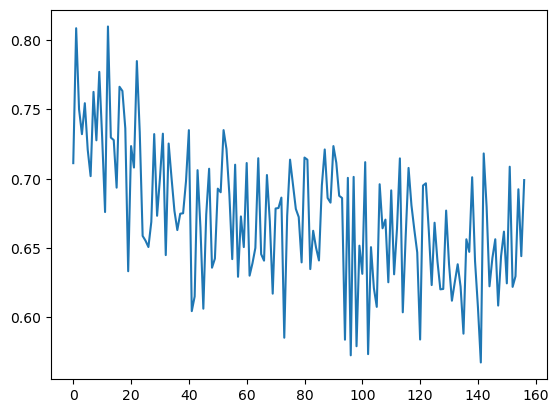

In [32]:
losses, acc=train_epoch(X_train, y_train)
all_losses.extend(losses)
print("accuracy: " , acc)
plt.plot(all_losses)

  0%|          | 0/156 [00:00<?, ?it/s]

accuracy:  88.6


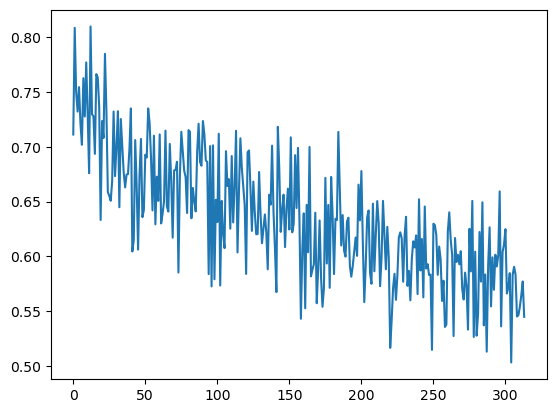

In [33]:
losses, acc=train_epoch(X_train, y_train)
all_losses.extend(losses)
print("accuracy: " , acc)
plt.plot(all_losses)

  0%|          | 0/156 [00:00<?, ?it/s]

accuracy:  95.075


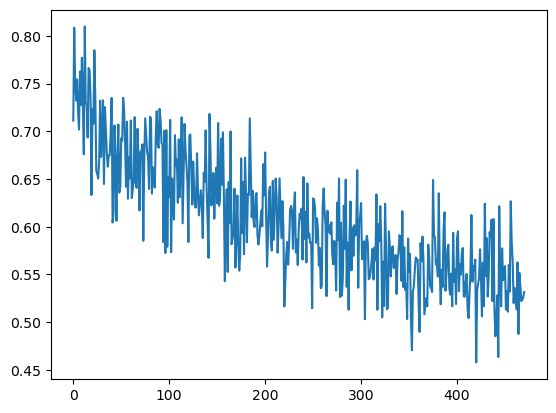

In [34]:
losses, acc=train_epoch(X_train, y_train)
all_losses.extend(losses)
print("accuracy: " , acc)
plt.plot(all_losses)